In [1]:
# Import Packages
import pandas as pd
import numpy as np
import os
import sys
import dtale
import holidays

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

%matplotlib inline


# Folder Structure
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

# Read Data
train = pd.read_csv(f"{DATA_DIR}/train_E1GspfA.csv")
test = pd.read_csv(f"{DATA_DIR}/test_6QvDdzb.csv")

print(train.shape, test.shape)
train.sample()

(18247, 3) (7650, 2)


date  hour  demand
11833  2020-04-05     6      79

In [2]:
test.sample()

date  hour
2103  2021-06-05    14

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [4]:
# Convert date and hour fields to one datetime field.
train['datetime'] = pd.to_datetime(train['date'] + " " + train['hour'].astype(str) + ":00:00", errors="coerce")
test['datetime'] = pd.to_datetime(test['date'] + " " + test['hour'].astype(str) + ":00:00", errors="coerce")

train = train[['datetime', 'demand']]
test = test[['datetime']]

In [5]:
train.sample()

datetime  demand
14444 2020-08-05 08:00:00      89

In [6]:
test.sample()

datetime
2697 2021-07-03 03:00:00

In [7]:
# Check graphs and other visualisations on dtale
dtale.show(train)

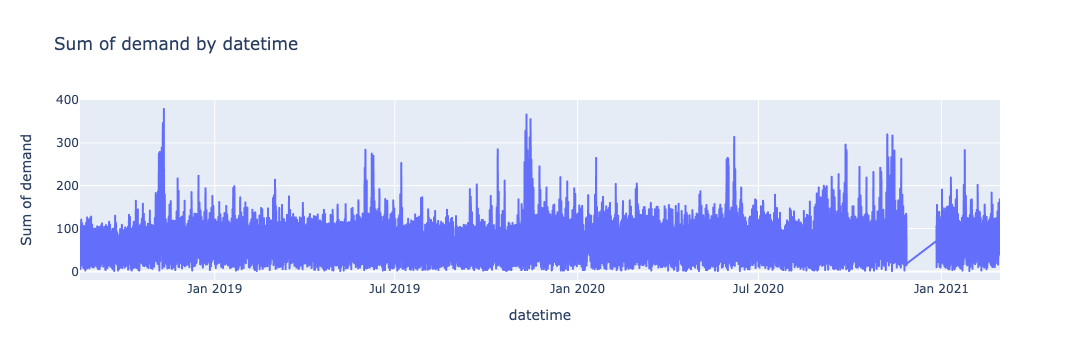

In [8]:
# Visualise the train dataset

if isinstance(train, (pd.DatetimeIndex, pd.MultiIndex)):
	train = train.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
train = train.reset_index().drop('index', axis=1, errors='ignore')
train.columns = [str(c) for c in train.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	train['datetime'],
	train['demand'],
], axis=1)
chart_data = chart_data.sort_values(['datetime'])
chart_data = chart_data.rename(columns={'datetime': 'x'})
chart_data_sum = chart_data.groupby(['x'])[['demand']].sum()
chart_data_sum.columns = ['demand|sum']
chart_data = chart_data_sum.reset_index()
chart_data = chart_data.dropna()

charts = []
line_cfg = {'line': {'shape': 'linear'}, 'mode': 'lines'}
charts.append(go.Scattergl(
	x=chart_data['x'], y=chart_data['demand|sum'], name='demand|sum', **line_cfg
))
figure = go.Figure(data=charts, layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Sum of demand by datetime'},
    'xaxis': {'title': {'text': 'datetime'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': 'Sum of demand'}, 'type': 'linear'}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)
for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

In [9]:
# There are missing elements in this dataset. So we accordingly split train-test
train.loc[(train['datetime'] >= '2020-11-27') & (train['datetime'] <"2020-12-27")] # Missing Values

Empty DataFrame
Columns: [datetime, demand]
Index: []

# CatBoost Regression

In [10]:
# Feature Engineering
def datetime_disintegration(df, col):

    df[f"{col}_day"] = df[col].dt.day
    df[f"{col}_week"] = df[col].dt.week
    df[f"{col}_month"] = df[col].dt.month
    df[f"{col}_quarter"] = df[col].dt.quarter
    df[f"{col}_year"] = df[col].dt.year
    df[f"{col}_hour"] = df[col].dt.hour
    df[f"{col}_minute"] = df[col].dt.minute
    df[f"{col}_second"] = df[col].dt.second
    df[f"{col}_weekday"] = df[col].dt.weekday
    # df[f"{col}_weekofyear"] = df[col].dt.weekofyear
    df[f"{col}_dayofyear"] = df[col].dt.dayofyear
    df[f"{col}_day_name"] = df[col].dt.day_name()
    df[f"{col}_is_month_start"] = df[col].dt.is_month_start
    df[f"{col}_is_month_end"] = df[col].dt.is_month_end
    df[f"{col}_is_quarter_start"] = df[col].dt.is_quarter_start
    df[f"{col}_is_quarter_end"] = df[col].dt.is_quarter_end
    df[f"{col}_is_year_start"] = df[col].dt.is_year_start
    df[f"{col}_is_year_end"] = df[col].dt.is_year_end
    df[f"{col}_is_leap_year"] = df[col].dt.is_leap_year
    df[f"{col}_days_in_month"] = df[col].dt.days_in_month
    
    return df

train_catboost = datetime_disintegration(train, 'datetime')
test_catboost = datetime_disintegration(test, 'datetime')
train_catboost.sample()

datetime  demand  datetime_day  datetime_week  \
13998 2020-07-14 09:00:00      38            14             29   

       datetime_month  datetime_quarter  datetime_year  datetime_hour  \
13998               7                 3           2020              9   

       datetime_minute  datetime_second  ...  datetime_dayofyear  \
13998                0                0  ...                 196   

       datetime_day_name datetime_is_month_start  datetime_is_month_end  \
13998            Tuesday                   False                  False   

       datetime_is_quarter_start  datetime_is_quarter_end  \
13998                      False                    False   

       datetime_is_year_start  datetime_is_year_end  datetime_is_leap_year  \
13998                   False                 False                   True   

       datetime_days_in_month  
13998                      31  

[1 rows x 21 columns]

In [11]:
# Tried checking if holidays affect car sales

in_holidays = holidays.IN()

holiday_dates = []
for date, name in sorted(holidays.IN(subdiv='KA', years=list(range(2017,2023))).items()):
    holiday_dates.append(date)
    # print(date, name)

# holiday_dates

In [12]:
train_catboost.loc[((train_catboost['datetime'].dt.date).isin(holiday_dates)), 'is_holiday'] = 1
train_catboost['is_holiday'] = train_catboost['is_holiday'].fillna(0)
test_catboost.loc[((test_catboost['datetime'].dt.date).isin(holiday_dates)), 'is_holiday'] = 1
test_catboost['is_holiday'] = test_catboost['is_holiday'].fillna(0)

In [13]:
train_catboost.columns

Index(['datetime', 'demand', 'datetime_day', 'datetime_week', 'datetime_month',
       'datetime_quarter', 'datetime_year', 'datetime_hour', 'datetime_minute',
       'datetime_second', 'datetime_weekday', 'datetime_dayofyear',
       'datetime_day_name', 'datetime_is_month_start', 'datetime_is_month_end',
       'datetime_is_quarter_start', 'datetime_is_quarter_end',
       'datetime_is_year_start', 'datetime_is_year_end',
       'datetime_is_leap_year', 'datetime_days_in_month', 'is_holiday'],
      dtype='object')

In [14]:
train_catboost['datetime'].min(), test_catboost['datetime'].max()

(Timestamp('2018-08-18 09:00:00'), Timestamp('2022-03-28 23:00:00'))

In [15]:
# Select features for training
features = [
    'datetime_hour',
    'datetime_day',
    # 'datetime_week',
    'datetime_weekday',
    # 'datetime_month',
    # 'datetime_quarter',
    # 'datetime_year', 
    'datetime_dayofyear'
    # 'is_holiday'
    # 'datetime_minute',
    # 'datetime_second',
    # 'datetime_is_month_start', 'datetime_is_month_end',
    # 'datetime_is_quarter_start', 'datetime_is_quarter_end',
    # 'datetime_is_year_start', 'datetime_is_year_end',
    # 'datetime_is_leap_year', 'datetime_days_in_month'
]

target = 'demand'

Xy = train_catboost.set_index('datetime')[features + [target]]
print(Xy.shape)

(18247, 5)


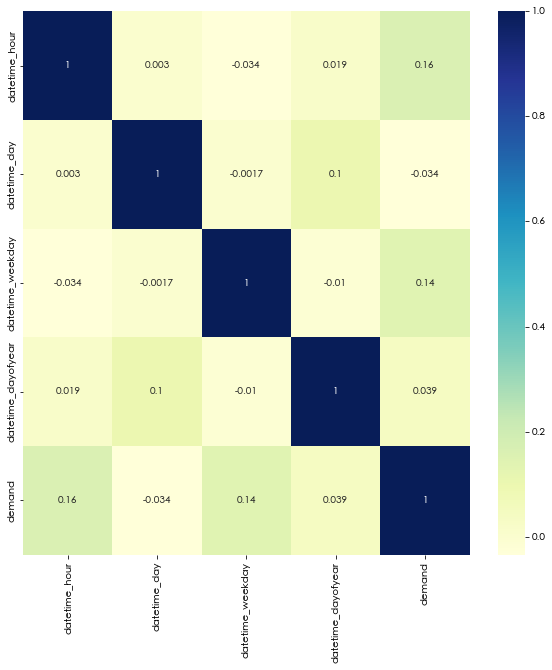

In [16]:
# Correlation plot
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(Xy.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [17]:
# Train-Val-Test split
Xy_train = Xy.loc[:'2020-08-01']
Xy_val = Xy.loc['2020-08-01':'2020-12-27']
Xy_test = Xy.loc['2020-12-27':]

X_train = Xy_train[features]
y_train = Xy_train[target]
X_val = Xy_val[features]
y_val = Xy_val[target]
X_test = Xy_test[features]
y_test = Xy_test[target]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(14375, 4) (14375,) (2496, 4) (2496,) (1419, 4) (1419,)


In [18]:
# Initialise CatBoost Regressor
version = 24
eval_metric = "MSLE"
max_depth = 10
lr = 0.1
early_stopping_rounds=500
l2 = 3

cb_model = CatBoostRegressor(
    n_estimators=100000,
    max_depth=max_depth,
    eval_metric=eval_metric,
    use_best_model=True,
    learning_rate=lr,
    early_stopping_rounds=early_stopping_rounds,
    has_time=True,
    random_seed=42
    # l2_leaf_reg=l2,
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# CatBoost GridSearch

In [39]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'eval_metric': 'MSLE'
       }

grid_cb_model = CatBoostRegressor()
grid_search_result = grid_cb_model.grid_search(
    param_grid=grid, 
    X=X_train, 
    y=y_train, 
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 83.0622998	test: 81.9294859	best: 81.9294859 (0)	total: 9.58ms	remaining: 9.57s
1:	learn: 81.1409551	test: 80.0150752	best: 80.0150752 (1)	total: 18.8ms	remaining: 9.39s
2:	learn: 79.3228852	test: 78.1986755	best: 78.1986755 (2)	total: 25.9ms	remaining: 8.61s
3:	learn: 77.5547304	test: 76.4336307	best: 76.4336307 (3)	total: 31.2ms	remaining: 7.78s
4:	learn: 75.8420968	test: 74.7226572	best: 74.7226572 (4)	total: 39.6ms	remaining: 7.88s
5:	learn: 74.1883452	test: 73.0743797	best: 73.0743797 (5)	total: 45.5ms	remaining: 7.54s
6:	learn: 72.5792089	test: 71.4664790	best: 71.4664790 (6)	total: 50.5ms	remaining: 7.16s
7:	learn: 71.0289338	test: 69.9191674	best: 69.9191674 (7)	total: 55.6ms	remaining: 6.89s
8:	learn: 69.5400921	test: 68.4285172	best: 68.4285172 (8)	total: 60.3ms	remaining: 6.64s
9:	learn: 68.1475058	test: 67.0377868	best: 67.0377868 (9)	total: 64.8ms	remaining: 6.42s
10:	learn: 66.8092774	test: 65.6997726	best: 65.6997726 (10)	total: 71.2ms	remaining: 6.4s
11:	learn

# CatBoost Regressor CV

In [34]:
# Xy_train = Xy.loc[:'2020-12-27']
# # Xy_val = Xy.loc['2020-08-01':'2020-12-27']
# Xy_test = Xy.loc['2020-12-27':]

# X_train = Xy_train[features]
# y_train = Xy_train[target]
# X_val = Xy_val[features]
# y_val = Xy_val[target]
# X_test = Xy_test[features]
# y_test = Xy_test[target]

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

# from catboost import Pool, cv
# cv_dataset = Pool(data=X_train,
#                   label=y_train,
#                   # cat_features=cat_features
#                  )

# params = {"iterations": 1000,
#           "max_depth": 8,
#           "loss_function": "RMSE",
#           "learning_rate": 0.1,
#           "verbose": False}

# scores = cv(cv_dataset,
#             params,
#             fold_count=2,
#             plot="True"
#            )

(16850, 4) (16850,) (2496, 4) (2496,) (1419, 4) (1419,)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 33.42162601
bestIteration = 308

Training on fold [1/2]

bestTest = 33.13474243
bestIteration = 346



In [19]:
# Check feature importances
feature_imp_df = pd.DataFrame.from_dict(
    dict(
        zip(
            cb_model.feature_names_, cb_model.feature_importances_
        )
    ),
    orient='index', 
    columns=['importance']
).reset_index(
).rename(
    columns={
        'index': 'feature'
    }
).sort_values('importance', ascending=False)
feature_imp_df


feature  importance
3  datetime_dayofyear   44.612476
0       datetime_hour   29.792200
2    datetime_weekday   15.049759
1        datetime_day   10.545565

In [20]:
# Predict and Evaluate catboost model
y_pred = cb_model.predict(X_test)

def get_regression_eval_metrics(y_test, y_pred):

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("R^2 : ", r2)
    print("MAE :", mae)
    print("RMSE:", rmse)
    
    return np.round(r2, 2), int(np.round(mae, 0)), int(np.round(rmse, 0))

r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)

# R^2 :  0.26722209915138817
# MAE : 27.04919418596021
# RMSE: 32.70660484797922

# R^2 :  0.2645663505114533
# MAE : 27.029056640668763
# RMSE: 32.76581921778622

# R^2 :  0.2641909825659208
# MAE : 27.035545927273557
# RMSE: 32.774180046297865

R^2 :  0.26293122632790666
MAE : 27.06199901991716
RMSE: 32.8022238865703


In [22]:
# Plot the tree to understand the split
cb_model.plot_tree(1)

In [23]:
# Check visualisation of test and pred set to understand the predictions accuracy.
pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
dtale.show(pred_df)

In [24]:
# Save file for submission
test_catboost['demand'] = pd.Series(np.round(cb_model.predict(test_catboost[features]),0), name='y_pred').astype(int)
test_catboost['date'] = test_catboost['datetime'].dt.date
test_catboost['hour'] = test_catboost['datetime'].dt.hour

submission = test_catboost[['date', 'hour', 'demand']]

submission.to_csv(f'{DATA_DIR}/v{version}_cb_{eval_metric}_{max_depth}_{lr}-{rmse}_{mae}_{r2}.csv', index=False) # _{l2}

In [ ]:
# ###########################
# v1: RMSE - max_depth=8
# R^2 :  0.2605607482255736
# MAE : 27.117987422351938
# RMSE: 32.8549289652779
# ###########################
# v2: MSLE - max_depth=8
# R^2 :  0.2665809910819359
# MAE : 27.058089429176192
# RMSE: 32.72090923948736
# ###########################
# v3: MSLE - max_depth=9,
# learning_rate=0.001,
# early_stopping_rounds=500
# R^2 :  0.26665031931250405
# MAE : 27.066371718803882
# RMSE: 32.71936269084083
# ###########################
# v4: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# R^2 :  0.26722209915138817
# MAE : 27.04919418596021
# RMSE: 32.70660484797922
# ###########################
# v5: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# added more features to datetime disintegrations
# R^2 :  0.27121773653411974
# MAE : 27.01415535982696
# RMSE: 32.61731287707521
# ###########################
# v6: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# added more features to datetime disintegrations
# removed few disintegrations like start and end
# R^2 :  0.2679991359776246
# MAE : 27.025361520648463
# RMSE: 32.689259225738354
# ###########################
# v7: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# added more features to datetime disintegrations
# removed more disintegrations
# R^2 :  0.27175001151679357
# MAE : 27.033405429358996
# RMSE: 32.60539947598217
# ###########################
# v8: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# added more features to datetime disintegrations
# removed more disintegrations
# R^2 :  0.2703342277015337
# MAE : 27.03869964648301
# RMSE: 32.63707800911575
# ###########################
# v9: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# feature	importance
# 0	datetime_hour	34.354990
# 2	datetime_dayofyear	31.304319
# 3	datetime_week	17.751193
# 1	datetime_weekday	16.589499
# R^2 :  0.2645958007779192
# MAE : 27.122256870104113
# RMSE: 32.76516316147969
# ###########################
# v4: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# R^2 :  0.26722209915138817
# MAE : 27.04919418596021
# RMSE: 32.70660484797922
# ###########################
# v11: v4 with features:
# feature	importance
# 3	datetime_dayofyear	39.730989
# 1	datetime_hour	35.045359
# 2	datetime_weekday	16.465270
# 0	datetime_month	8.758382
# R^2 :  0.26940139045007483
# MAE : 27.007140177933337
# RMSE: 32.65793369327185
# ###########################
# v12: added regularization, reduced lr
# chose features using corr
# n_estimators=100000,
# max_depth=8,
# eval_metric="MSLE",
# use_best_model=True,
# learning_rate=0.1,
# early_stopping_rounds=50,
# has_time=True,
# l2_leaf_reg= 5
# feature	importance
# 4	datetime_dayofyear	38.177541
# 0	datetime_hour	32.285405
# 2	datetime_weekday	13.357217
# 1	datetime_day	8.689904
# 3	datetime_year	7.489933
# R^2 :  0.2555755442450015
# MAE : 27.248446094172333
# RMSE: 32.96549476813209
# ###########################
# v13: v12 - lr reduced to 0.01
# R^2 :  0.264535073930668
# MAE : 27.10506548155467
# RMSE: 32.766515944062604
# ###########################
# v14: v12 - l2_reg=6
# R^2 :  0.26197757454715676
# MAE : 27.07628423577965
# RMSE: 32.823437502183666
# ###########################
# v15: v13 - l2_reg=4
# R^2 :  0.25880196361936614
# MAE : 27.139968806984037
# RMSE: 32.89397911250799
# ###########################
# v16: 
# n_estimators=100000,
# max_depth=8,
# eval_metric="MSLE",
# use_best_model=True,
# learning_rate=0.1,
# early_stopping_rounds=50,
# has_time=True,
# l2_leaf_reg=5
# feature	importance
# 3	datetime_dayofyear	44.501882
# 0	datetime_hour	33.227471
# 1	datetime_weekday	14.462021
# 2	datetime_year	7.808626
# R^2 :  0.26573838745994127
# MAE : 27.193682376909322
# RMSE: 32.7396998912443
# ###########################
# v18
# version = 18
# eval_metric = "MSLE"
# max_depth = 8
# lr = 0.0005
# l2 = 5
# feature	importance
# 4	datetime_dayofyear	39.168844
# 0	datetime_hour	30.520318
# 2	datetime_weekday	14.175735
# 1	datetime_day	8.678823
# 3	datetime_year	7.456279
# R^2 :  0.2652889074478665
# MAE : 27.083461337433604
# RMSE: 32.749719201157745
# ###########################